# 테슬라 예측

In [1]:
!pip install statsmodels

In [2]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.4.2
1.1.2
0.13.5


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/Documents/aiffel/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2022-03-23    333.036682
2022-03-24    337.973328
2022-03-25    336.880005
2022-03-28    363.946655
2022-03-29    366.523346
Name: Close, dtype: float64

In [4]:
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [5]:
from statsmodels.tsa.stattools import adfuller

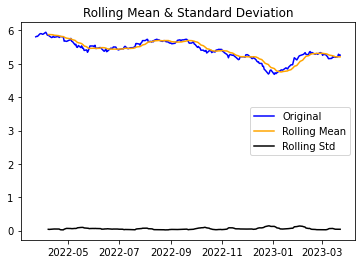

In [6]:
ts_log = np.log(ts)
# 정성적 그래프 분석
# 일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)



In [7]:

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test : ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    
    print(dfoutput)
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)


Results of Dickey-Fuller Test : 
Test Statistic                  -2.345130
p-value                          0.157825
#Lags Used                       9.000000
Number of Observations Used    242.000000
Critical Value 1%               -3.457664
Critical Value 5%               -2.873559
Critical Value 10%              -2.573175
dtype: float64


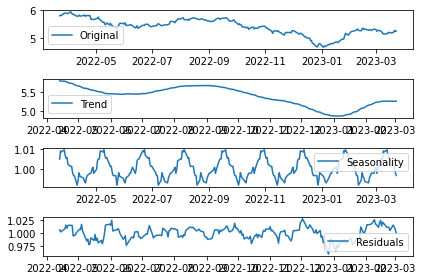

In [8]:

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test : 
Test Statistic                  -4.263585
p-value                          0.000513
#Lags Used                       9.000000
Number of Observations Used    212.000000
Critical Value 1%               -3.461578
Critical Value 5%               -2.875272
Critical Value 10%              -2.574089
dtype: float64


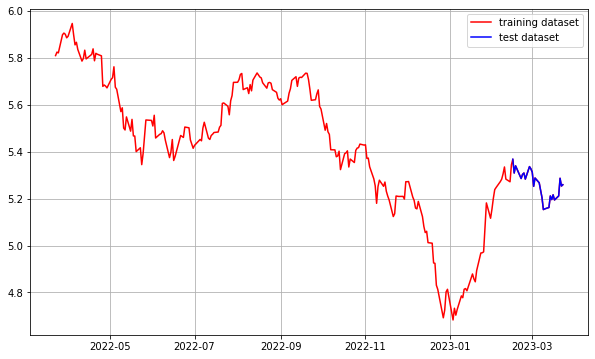

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


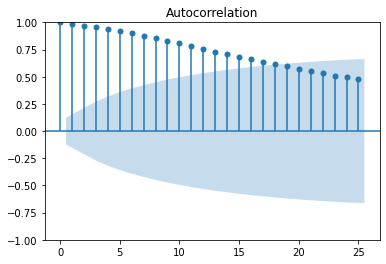

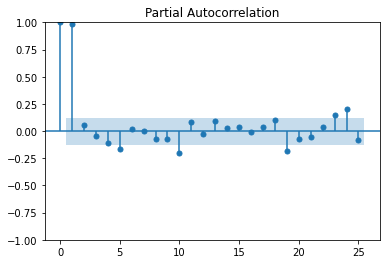

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test : 
Test Statistic                  -3.614850
p-value                          0.005483
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value 1%               -3.457664
Critical Value 5%               -2.873559
Critical Value 10%              -2.573175
dtype: float64
Results of Dickey-Fuller Test : 
Test Statistic                -1.103272e+01
p-value                        5.615618e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value 1%             -3.457664e+00
Critical Value 5%             -2.873559e+00
Critical Value 10%            -2.573175e+00
dtype: float64


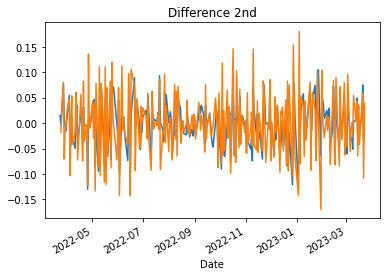

In [12]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [13]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 388.640
Date:                Fri, 24 Mar 2023   AIC                           -767.279
Time:                        12:10:50   BIC                           -750.176
Sample:                             0   HQIC                          -760.377
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4952      0.191     28.737      0.000       5.120       5.870
ar.L1          0.0153      0.222      0.069      0.945      -0.420       0.451
ar.L2          0.9623      0.227      4.243      0.0

/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


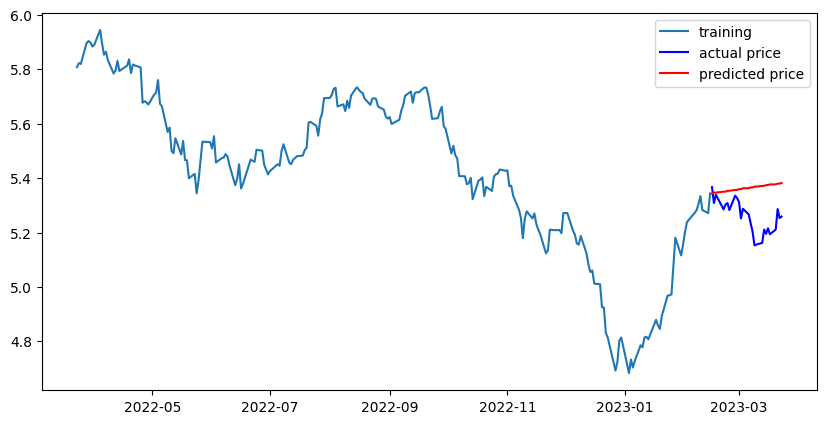

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [15]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  618.0827985488512
MAE:  21.510467573817664
RMSE:  24.861271056582186
MAPE: 11.60%


# nvidia 예측

1.4.2
1.1.2
0.13.5


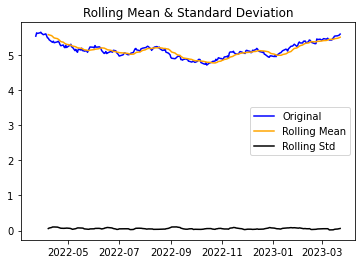

Results of Dickey-Fuller Test : 
Test Statistic                  -1.262393
p-value                          0.646197
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value 1%               -3.456674
Critical Value 5%               -2.873125
Critical Value 10%              -2.572944
dtype: float64
Results of Dickey-Fuller Test : 
Test Statistic                  -5.318780
p-value                          0.000005
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value 1%               -3.460291
Critical Value 5%               -2.874709
Critical Value 10%              -2.573789
dtype: float64


/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


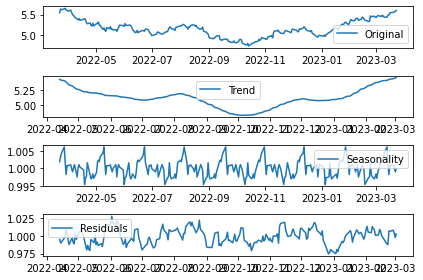

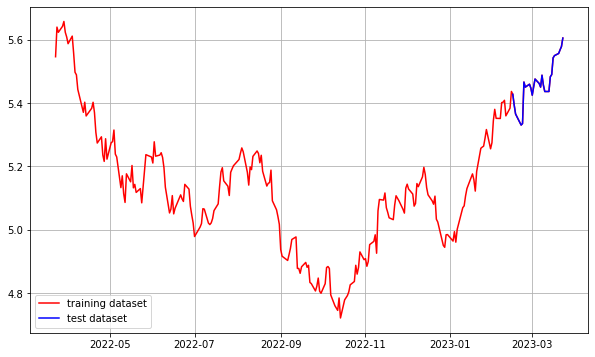

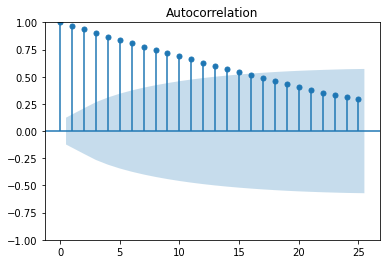

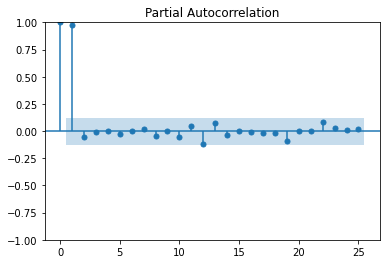

Results of Dickey-Fuller Test : 
Test Statistic                -1.606461e+01
p-value                        5.590998e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value 1%             -3.456781e+00
Critical Value 5%             -2.873172e+00
Critical Value 10%            -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test : 
Test Statistic                -9.364039e+00
p-value                        7.685516e-16
#Lags Used                     9.000000e+00
Number of Observations Used    2.400000e+02
Critical Value 1%             -3.457894e+00
Critical Value 5%             -2.873659e+00
Critical Value 10%            -2.573229e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 410.095
Date:                Fri, 24 Mar 2023   AIC        

/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary startin

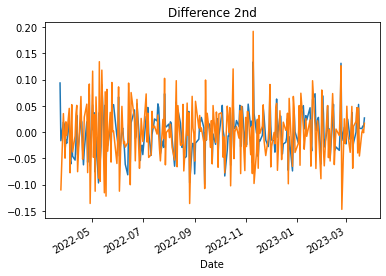

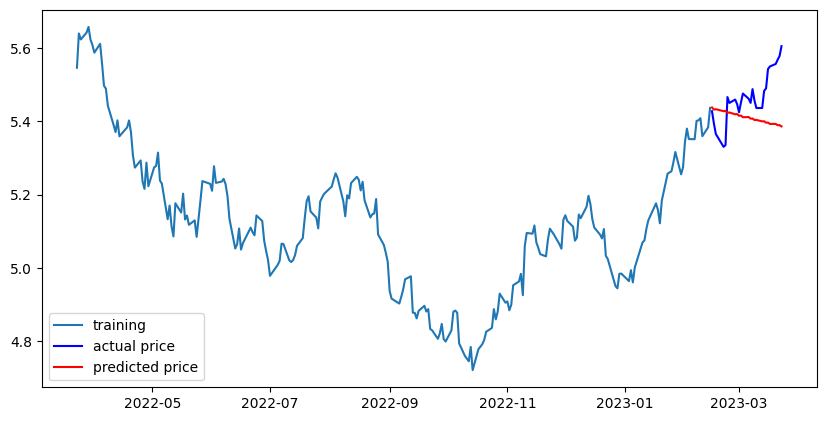

MSE:  550.0884403076375
MAE:  18.681451925285735
RMSE:  23.45396427701802
MAPE: 7.62%


In [16]:
# 테슬라 예측

!pip install statsmodels

import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/Documents/aiffel/NVDA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

from statsmodels.tsa.stattools import adfuller

ts_log = np.log(ts)
# 정성적 그래프 분석
# 일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)




def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test : ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    
    print(dfoutput)
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)



#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


# micro soft 예측

1.4.2
1.1.2
0.13.5


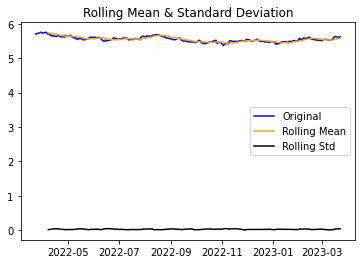

Results of Dickey-Fuller Test : 
Test Statistic                  -2.587856
p-value                          0.095533
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value 1%               -3.456674
Critical Value 5%               -2.873125
Critical Value 10%              -2.572944
dtype: float64
Results of Dickey-Fuller Test : 
Test Statistic                -5.690423e+00
p-value                        8.095198e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.200000e+02
Critical Value 1%             -3.460428e+00
Critical Value 5%             -2.874769e+00
Critical Value 10%            -2.573821e+00
dtype: float64


/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


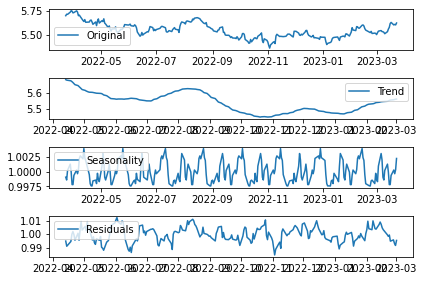

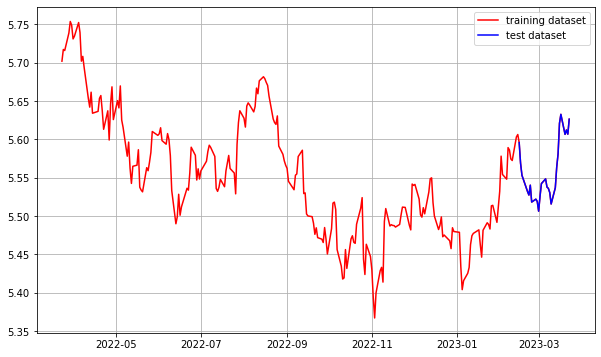

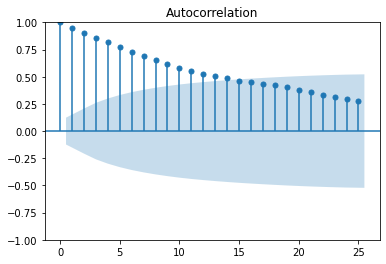

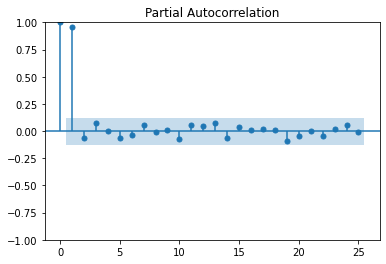

Results of Dickey-Fuller Test : 
Test Statistic                -1.232654e+01
p-value                        6.569744e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.490000e+02
Critical Value 1%             -3.456888e+00
Critical Value 5%             -2.873219e+00
Critical Value 10%            -2.572994e+00
dtype: float64
Results of Dickey-Fuller Test : 
Test Statistic                -8.210297e+00
p-value                        6.847278e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value 1%             -3.458128e+00
Critical Value 5%             -2.873762e+00
Critical Value 10%            -2.573283e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 539.076
Date:                Fri, 24 Mar 2023   AIC        

/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/doeun/anaconda3/envs/maskYolov5Project/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary startin

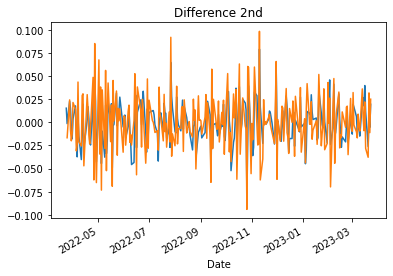

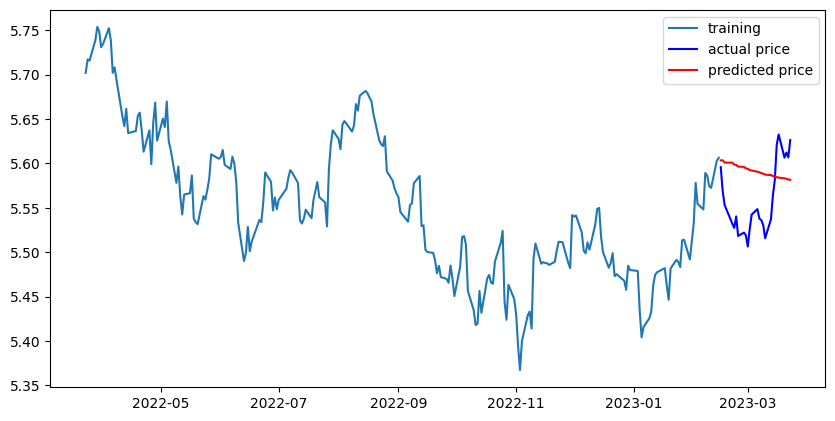

MSE:  197.26708197489688
MAE:  12.917212783439545
RMSE:  14.045180026432444
MAPE: 5.04%


In [1]:
# 테슬라 예측

!pip install statsmodels

import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/Documents/aiffel/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

from statsmodels.tsa.stattools import adfuller

ts_log = np.log(ts)
# 정성적 그래프 분석
# 일정 시간 내 구간 통계치(Rolling Statistics) 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='orange', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)




def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller메소드를 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    # adfuller메소드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test : ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
    
    print(dfoutput)
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)



#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
